In [1]:
### We create our log file

In [2]:
## %matplotlib inline
import matplotlib.pyplot as plt
import requests, re, time
from bs4 import BeautifulSoup
import scraping_class
import pprint
import pandas as pd
import numpy as np
import pickle
logfile = 'the_log.csv'## name your log file.
connector = scraping_class.Connector(logfile)
session = requests.session()
session.headers['mkp244@alumni.ku.dk'] = 'mkp244@alumni.ku.dk' 
session.headers['Oluf Kelkjær'] = 'Oluf Kelkjær'
session.headers


{'User-Agent': 'python-requests/2.22.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'mkp244@alumni.ku.dk': 'mkp244@alumni.ku.dk', 'Oluf Kelkjær': 'Oluf Kelkjær'}

In [3]:
import requests

In [4]:
url=[]
for n in range (1,5251,250):
    url.append('https://www.imdb.com/search/title/?title_type=feature&num_votes=20000,&sort=moviemeter,desc&count=250&start=' + str(n) + '&ref_=adv_nxt')
   


links = []
import time
for x in url:
    time.sleep(0.5)
    response = requests.get(x)
    if response.ok:
        html = response.text
    else:
        print('error')
    BeautifulSoup(html,'html.parser')
    link_location = html.split('href="')[1:]
    


    for link_loc in link_location:
        link = link_loc.split('"')[0].strip('title_type')      #-> check om det kan ekskluderes bagefter
        if '/title/' in link:
            links.append(link) 


links = ['https://www.imdb.com/'+link for link in links if not 'plotsummar' in link and not 'title_type' in link and not 'ref' in link and not 'plotsummary' in link and not 'vote' in link] # add the domain to each link
links=set(links)
links


{'https://www.imdb.com//title/tt0065938/',
 'https://www.imdb.com//title/tt0119951/',
 'https://www.imdb.com//title/tt0100263/',
 'https://www.imdb.com//title/tt1289401/',
 'https://www.imdb.com//title/tt0120053/',
 'https://www.imdb.com//title/tt0377752/',
 'https://www.imdb.com//title/tt0454876/',
 'https://www.imdb.com//title/tt0453467/',
 'https://www.imdb.com//title/tt0042593/',
 'https://www.imdb.com//title/tt0089092/',
 'https://www.imdb.com//title/tt4651520/',
 'https://www.imdb.com//title/tt0054387/',
 'https://www.imdb.com//title/tt4846340/',
 'https://www.imdb.com//title/tt0443543/',
 'https://www.imdb.com//title/tt6772950/',
 'https://www.imdb.com//title/tt3623726/',
 'https://www.imdb.com//title/tt0356680/',
 'https://www.imdb.com//title/tt0368794/',
 'https://www.imdb.com//title/tt3799232/',
 'https://www.imdb.com//title/tt0146316/',
 'https://www.imdb.com//title/tt1549920/',
 'https://www.imdb.com//title/tt1333125/',
 'https://www.imdb.com//title/tt5247022/',
 'https://w

In [5]:
links=set(links)
len(links)


5271

### Parsing HTML with BeautifulSoup

When parsing, we took advantage of the pyhton library BeautifulSoup. 

"BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable."

In [6]:
def find_budget(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Budget:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_gross(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Cumulative Worldwide Gross:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_grossUSA(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Gross USA:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))

def find_rating(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="ratingValue"):
        return float(i.text.strip().split("/")[0])
        
def find_runtime(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Runtime:":
            return float(i.text.strip().split("\n")[1].split("min")[0].strip())
def find_date(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Release Date:":
            return i.text.strip().split(":")[1].split("(")[0].strip()
        
def find_genre(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="subtext"):
        if str(i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(","))[-3]==(')'):
            return i.text.strip().split("|")[1].replace('\n','').replace(' ','').split(",")
        else:
            return i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(",")


### Parsing and cleaning the data 

Here we use our earlier defined functions to make a dictionary of all the data we need from the description page of each movie, ie. title, budget, the cumulative worldwide gross, the rating, the runtime, date and genre.


In [7]:
def page_extractor(url):
    r, call_id = connector.get(url, "LOL")
    try:
        soup = BeautifulSoup(r.text, "html.parser")
        title = soup.select("#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper > h1")[0].text.split("\xa0")[0]
        budget = find_budget(soup)
        cumulative_worldwide_gross=find_gross(soup)
        gross_usa=find_grossUSA(soup)
        rating = find_rating(soup)
        runtime = find_runtime(soup)
        date= find_date(soup)
        genre = find_genre(soup)
    except:
        soup = None
        title = None
        budget = None
        cumulative_worldwide_gross= None
        gross_usa = None
        rating=None
        runtime = None
        date = None
        genre = None
    return {
        "title": title,
        #"year": year,
        "budget": budget,
        "url": url,
        "cumulative_world_gross": cumulative_worldwide_gross,
        "gross_usa": gross_usa,
        "rating": rating,
        "runtime": runtime,
        "date": date,
        "genre": genre
    }


### Create a list and append information from every movie on the list. 
Remark: We have only chosen top 250 so far, as to not make the coding too slow in progress. If you wish to see the whole list, or a minor part of it, simply change the brackets after 'links'.



In [77]:
# res = []
# for idx, i in enumerate(links):
#     print(idx + 1, "of", len(links))
#     res.append(page_extractor(i))


1 of 5272
2 of 5272
3 of 5272
4 of 5272
5 of 5272
6 of 5272
7 of 5272
8 of 5272
9 of 5272
10 of 5272
11 of 5272
12 of 5272
13 of 5272
14 of 5272
15 of 5272
16 of 5272
17 of 5272
18 of 5272
19 of 5272
20 of 5272
21 of 5272
22 of 5272
23 of 5272
24 of 5272
25 of 5272
26 of 5272
27 of 5272
28 of 5272
29 of 5272
30 of 5272
31 of 5272
32 of 5272
33 of 5272
34 of 5272
35 of 5272
36 of 5272
37 of 5272
38 of 5272
39 of 5272
40 of 5272
41 of 5272
42 of 5272
43 of 5272
44 of 5272
45 of 5272
46 of 5272
47 of 5272
48 of 5272
49 of 5272
50 of 5272
51 of 5272
52 of 5272
53 of 5272
54 of 5272
55 of 5272
56 of 5272
57 of 5272
58 of 5272
59 of 5272
60 of 5272
61 of 5272
62 of 5272
63 of 5272
64 of 5272
65 of 5272
66 of 5272
67 of 5272
68 of 5272
69 of 5272
70 of 5272
71 of 5272
72 of 5272
73 of 5272
74 of 5272
75 of 5272
76 of 5272
77 of 5272
78 of 5272
79 of 5272
80 of 5272
81 of 5272
82 of 5272
83 of 5272
84 of 5272
85 of 5272
86 of 5272
87 of 5272
88 of 5272
89 of 5272
90 of 5272
91 of 5272
92 of 52

693 of 5272
694 of 5272
695 of 5272
696 of 5272
697 of 5272
698 of 5272
699 of 5272
700 of 5272
701 of 5272
702 of 5272
703 of 5272
704 of 5272
705 of 5272
706 of 5272
707 of 5272
708 of 5272
709 of 5272
710 of 5272
711 of 5272
712 of 5272
713 of 5272
714 of 5272
715 of 5272
716 of 5272
717 of 5272
718 of 5272
719 of 5272
720 of 5272
721 of 5272
722 of 5272
723 of 5272
724 of 5272
725 of 5272
726 of 5272
727 of 5272
728 of 5272
729 of 5272
730 of 5272
731 of 5272
732 of 5272
733 of 5272
734 of 5272
735 of 5272
736 of 5272
737 of 5272
738 of 5272
739 of 5272
740 of 5272
741 of 5272
742 of 5272
743 of 5272
744 of 5272
745 of 5272
746 of 5272
747 of 5272
748 of 5272
749 of 5272
750 of 5272
751 of 5272
752 of 5272
753 of 5272
754 of 5272
755 of 5272
756 of 5272
757 of 5272
758 of 5272
759 of 5272
760 of 5272
761 of 5272
762 of 5272
763 of 5272
764 of 5272
765 of 5272
766 of 5272
767 of 5272
768 of 5272
769 of 5272
770 of 5272
771 of 5272
772 of 5272
773 of 5272
774 of 5272
775 of 5272
776 

1347 of 5272
1348 of 5272
1349 of 5272
1350 of 5272
1351 of 5272
1352 of 5272
1353 of 5272
1354 of 5272
1355 of 5272
1356 of 5272
1357 of 5272
1358 of 5272
1359 of 5272
1360 of 5272
1361 of 5272
1362 of 5272
1363 of 5272
1364 of 5272
1365 of 5272
1366 of 5272
1367 of 5272
1368 of 5272
1369 of 5272
1370 of 5272
1371 of 5272
1372 of 5272
1373 of 5272
1374 of 5272
1375 of 5272
1376 of 5272
1377 of 5272
1378 of 5272
1379 of 5272
1380 of 5272
1381 of 5272
1382 of 5272
1383 of 5272
1384 of 5272
1385 of 5272
1386 of 5272
1387 of 5272
1388 of 5272
1389 of 5272
1390 of 5272
1391 of 5272
1392 of 5272
1393 of 5272
1394 of 5272
1395 of 5272
1396 of 5272
1397 of 5272
1398 of 5272
1399 of 5272
1400 of 5272
1401 of 5272
1402 of 5272
1403 of 5272
1404 of 5272
1405 of 5272
1406 of 5272
1407 of 5272
1408 of 5272
1409 of 5272
1410 of 5272
1411 of 5272
1412 of 5272
1413 of 5272
1414 of 5272
1415 of 5272
1416 of 5272
1417 of 5272
1418 of 5272
1419 of 5272
1420 of 5272
1421 of 5272
1422 of 5272
1423 of 5272

1978 of 5272
1979 of 5272
1980 of 5272
1981 of 5272
1982 of 5272
1983 of 5272
1984 of 5272
1985 of 5272
1986 of 5272
1987 of 5272
1988 of 5272
1989 of 5272
1990 of 5272
1991 of 5272
1992 of 5272
1993 of 5272
1994 of 5272
1995 of 5272
1996 of 5272
1997 of 5272
1998 of 5272
1999 of 5272
2000 of 5272
2001 of 5272
2002 of 5272
2003 of 5272
2004 of 5272
2005 of 5272
2006 of 5272
2007 of 5272
2008 of 5272
2009 of 5272
2010 of 5272
2011 of 5272
2012 of 5272
2013 of 5272
2014 of 5272
2015 of 5272
2016 of 5272
2017 of 5272
2018 of 5272
2019 of 5272
2020 of 5272
2021 of 5272
2022 of 5272
2023 of 5272
2024 of 5272
2025 of 5272
2026 of 5272
2027 of 5272
2028 of 5272
2029 of 5272
2030 of 5272
2031 of 5272
2032 of 5272
2033 of 5272
2034 of 5272
2035 of 5272
2036 of 5272
2037 of 5272
2038 of 5272
2039 of 5272
2040 of 5272
2041 of 5272
2042 of 5272
2043 of 5272
2044 of 5272
2045 of 5272
2046 of 5272
2047 of 5272
2048 of 5272
2049 of 5272
2050 of 5272
2051 of 5272
2052 of 5272
2053 of 5272
2054 of 5272

2609 of 5272
2610 of 5272
2611 of 5272
2612 of 5272
2613 of 5272
2614 of 5272
2615 of 5272
2616 of 5272
2617 of 5272
2618 of 5272
2619 of 5272
2620 of 5272
2621 of 5272
2622 of 5272
2623 of 5272
2624 of 5272
2625 of 5272
2626 of 5272
2627 of 5272
2628 of 5272
2629 of 5272
2630 of 5272
2631 of 5272
2632 of 5272
2633 of 5272
2634 of 5272
2635 of 5272
2636 of 5272
2637 of 5272
2638 of 5272
2639 of 5272
2640 of 5272
2641 of 5272
2642 of 5272
2643 of 5272
2644 of 5272
2645 of 5272
2646 of 5272
2647 of 5272
2648 of 5272
2649 of 5272
2650 of 5272
2651 of 5272
2652 of 5272
2653 of 5272
2654 of 5272
2655 of 5272
2656 of 5272
2657 of 5272
2658 of 5272
2659 of 5272
2660 of 5272
2661 of 5272
2662 of 5272
2663 of 5272
2664 of 5272
2665 of 5272
2666 of 5272
2667 of 5272
2668 of 5272
2669 of 5272
2670 of 5272
2671 of 5272
2672 of 5272
2673 of 5272
2674 of 5272
2675 of 5272
2676 of 5272
2677 of 5272
2678 of 5272
2679 of 5272
2680 of 5272
2681 of 5272
2682 of 5272
2683 of 5272
2684 of 5272
2685 of 5272

3240 of 5272
3241 of 5272
3242 of 5272
3243 of 5272
3244 of 5272
3245 of 5272
3246 of 5272
3247 of 5272
3248 of 5272
3249 of 5272
3250 of 5272
3251 of 5272
3252 of 5272
3253 of 5272
3254 of 5272
3255 of 5272
3256 of 5272
3257 of 5272
3258 of 5272
3259 of 5272
3260 of 5272
3261 of 5272
3262 of 5272
3263 of 5272
3264 of 5272
3265 of 5272
3266 of 5272
3267 of 5272
3268 of 5272
3269 of 5272
3270 of 5272
3271 of 5272
3272 of 5272
3273 of 5272
3274 of 5272
3275 of 5272
3276 of 5272
3277 of 5272
3278 of 5272
3279 of 5272
3280 of 5272
3281 of 5272
3282 of 5272
3283 of 5272
3284 of 5272
3285 of 5272
3286 of 5272
3287 of 5272
3288 of 5272
3289 of 5272
3290 of 5272
3291 of 5272
3292 of 5272
3293 of 5272
3294 of 5272
3295 of 5272
3296 of 5272
3297 of 5272
3298 of 5272
3299 of 5272
3300 of 5272
3301 of 5272
3302 of 5272
3303 of 5272
3304 of 5272
3305 of 5272
3306 of 5272
3307 of 5272
3308 of 5272
3309 of 5272
3310 of 5272
3311 of 5272
3312 of 5272
3313 of 5272
3314 of 5272
3315 of 5272
3316 of 5272

3871 of 5272
3872 of 5272
3873 of 5272
3874 of 5272
3875 of 5272
3876 of 5272
3877 of 5272
3878 of 5272
3879 of 5272
3880 of 5272
3881 of 5272
3882 of 5272
3883 of 5272
3884 of 5272
3885 of 5272
3886 of 5272
3887 of 5272
3888 of 5272
3889 of 5272
3890 of 5272
3891 of 5272
3892 of 5272
3893 of 5272
3894 of 5272
3895 of 5272
3896 of 5272
3897 of 5272
3898 of 5272
3899 of 5272
3900 of 5272
3901 of 5272
3902 of 5272
3903 of 5272
3904 of 5272
3905 of 5272
3906 of 5272
3907 of 5272
3908 of 5272
3909 of 5272
3910 of 5272
3911 of 5272
3912 of 5272
3913 of 5272
3914 of 5272
3915 of 5272
3916 of 5272
3917 of 5272
3918 of 5272
3919 of 5272
3920 of 5272
3921 of 5272
3922 of 5272
3923 of 5272
3924 of 5272
3925 of 5272
3926 of 5272
3927 of 5272
3928 of 5272
3929 of 5272
3930 of 5272
3931 of 5272
3932 of 5272
3933 of 5272
3934 of 5272
3935 of 5272
3936 of 5272
3937 of 5272
3938 of 5272
3939 of 5272
3940 of 5272
3941 of 5272
3942 of 5272
3943 of 5272
3944 of 5272
3945 of 5272
3946 of 5272
3947 of 5272

4502 of 5272
4503 of 5272
4504 of 5272
4505 of 5272
4506 of 5272
4507 of 5272
4508 of 5272
4509 of 5272
4510 of 5272
4511 of 5272
4512 of 5272
4513 of 5272
4514 of 5272
4515 of 5272
4516 of 5272
4517 of 5272
4518 of 5272
4519 of 5272
4520 of 5272
4521 of 5272
4522 of 5272
4523 of 5272
4524 of 5272
4525 of 5272
4526 of 5272
4527 of 5272
4528 of 5272
4529 of 5272
4530 of 5272
4531 of 5272
4532 of 5272
4533 of 5272
4534 of 5272
4535 of 5272
4536 of 5272
4537 of 5272
4538 of 5272
4539 of 5272
4540 of 5272
4541 of 5272
4542 of 5272
4543 of 5272
4544 of 5272
4545 of 5272
4546 of 5272
4547 of 5272
4548 of 5272
4549 of 5272
4550 of 5272
4551 of 5272
4552 of 5272
4553 of 5272
4554 of 5272
4555 of 5272
4556 of 5272
4557 of 5272
4558 of 5272
4559 of 5272
4560 of 5272
4561 of 5272
4562 of 5272
4563 of 5272
4564 of 5272
4565 of 5272
4566 of 5272
4567 of 5272
4568 of 5272
4569 of 5272
4570 of 5272
4571 of 5272
4572 of 5272
4573 of 5272
4574 of 5272
4575 of 5272
4576 of 5272
4577 of 5272
4578 of 5272

5133 of 5272
5134 of 5272
5135 of 5272
5136 of 5272
5137 of 5272
5138 of 5272
5139 of 5272
5140 of 5272
5141 of 5272
5142 of 5272
5143 of 5272
5144 of 5272
5145 of 5272
5146 of 5272
5147 of 5272
5148 of 5272
5149 of 5272
5150 of 5272
5151 of 5272
5152 of 5272
5153 of 5272
5154 of 5272
5155 of 5272
5156 of 5272
5157 of 5272
5158 of 5272
5159 of 5272
5160 of 5272
5161 of 5272
5162 of 5272
5163 of 5272
5164 of 5272
5165 of 5272
5166 of 5272
5167 of 5272
5168 of 5272
5169 of 5272
5170 of 5272
5171 of 5272
5172 of 5272
5173 of 5272
5174 of 5272
5175 of 5272
5176 of 5272
5177 of 5272
5178 of 5272
5179 of 5272
5180 of 5272
5181 of 5272
5182 of 5272
5183 of 5272
5184 of 5272
5185 of 5272
5186 of 5272
5187 of 5272
5188 of 5272
5189 of 5272
5190 of 5272
5191 of 5272
5192 of 5272
5193 of 5272
5194 of 5272
5195 of 5272
5196 of 5272
5197 of 5272
5198 of 5272
5199 of 5272
5200 of 5272
5201 of 5272
5202 of 5272
5203 of 5272
5204 of 5272
5205 of 5272
5206 of 5272
5207 of 5272
5208 of 5272
5209 of 5272

In [78]:
res


[{'title': 'Recep Ivedik',
  'budget': 500000.0,
  'url': 'https://www.imdb.com//title/tt1193516/',
  'cumulative_world_gross': 28548025.0,
  'gross_usa': None,
  'rating': 4.6,
  'runtime': 90.0,
  'date': '16 May 2008',
  'genre': ['Comedy']},
 {'title': 'Breaking Dawn - del 1',
  'budget': 110000000.0,
  'url': 'https://www.imdb.com//title/tt1324999/',
  'cumulative_world_gross': 712205856.0,
  'gross_usa': 281287133.0,
  'rating': 4.9,
  'runtime': 117.0,
  'date': '17 November 2011',
  'genre': ['Action', 'Adventure', 'Drama']},
 {'title': 'Giftig viden',
  'budget': 3500000.0,
  'url': 'https://www.imdb.com//title/tt1615147/',
  'cumulative_world_gross': 19504039.0,
  'gross_usa': 5354039.0,
  'rating': 7.1,
  'runtime': 107.0,
  'date': '29 September 2011',
  'genre': ['Drama', 'Thriller']},
 {'title': 'En lang forlovelse',
  'budget': 56600000.0,
  'url': 'https://www.imdb.com//title/tt0344510/',
  'cumulative_world_gross': 69424389.0,
  'gross_usa': 6524389.0,
  'rating': 7.6,

### Making our list into a dataframe, and applying datetime to the releasedate

A dataframe is basically just when a list has both several columns and rows, if there's only one row it's an array.

Remember to comment on the string lengths need to be over 4 characters.


In [10]:
# df = pd.DataFrame(res).dropna()

# df = df[df['date'].str.len() > 4]

# def preparedatetime(dataframe):
#     dataframe['datetime'] = pd.to_datetime(dataframe['date'], format = '%d %B %Y')
#     dataframe['year'] = dataframe.datetime.dt.year
#     dataframe['month'] = dataframe.datetime.dt.month
#     dataframe['day'] = dataframe.datetime.dt.day
#     return dataframe

# df = preparedatetime(df)
# df
# df.to_pickle('all_movies.csv') #saves relatively as csv 
#df.to_pickle('all_movies.pkl')
# #This command will load dataset from pkl or csv file
# df = pd.read_pickle('all_movies.csv')
# # or
df = pd.read_pickle('all_movies.pkl')
df

,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,title,url,datetime,year,month,day
1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,Breaking Dawn - del 1,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,11,17
2,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,Giftig viden,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,9,29
3,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,En lang forlovelse,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,1,21
4,175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,"Du almægtige, Evan",https://www.imdb.com//title/tt0413099/,2007-07-27,2007,7,27
6,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,Little Miss Sunshine,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,11,17
7,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,Det hemmelighedsfulde selskab,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,9,26
8,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,Lords of Dogtown,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,6,3
9,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,Freddy Got Fingered,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,5,24
10,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,Lunefulde måne,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,3,25
12,12000000.0,5.222331e+07,29 November 2002,"[Drama, Thriller]",31597131.0,6.8,96.0,One Hour Photo,https://www.imdb.com//title/tt0265459/,2002-11-29,2002,11,29


In [11]:
categories = set()
for i in df["genre"].apply(set).tolist():
    for j in i:
        categories.add(j)
#categories= set(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
#                'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
#                'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller'])
df2 = pd.concat([df, pd.DataFrame(columns=categories)], axis=1)


In [24]:
def df_dummy(df, col):
    return df.apply(lambda x: col in x["genre"], axis=1)

for i in categories:
    df2[i] = df_dummy(df2, i)
    df2[i] = pd.get_dummies(df2[i], drop_first = True)


df2 = df2.set_index(df['title'])
del df2['title']

df2


,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Music,Western,Biography,Crime,Animation,Thriller,Horror,Musical,Mystery,Drama
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,0,0,0,0,0,0,0,0,0,1
Giftig viden,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,0,0,0,0,1,0,0,0,1
En lang forlovelse,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,0,0,0,0,0,0,0,0,1,1
"Du almægtige, Evan",175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,0,0,0,0,0,0,0,0
Little Miss Sunshine,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,...,0,0,0,0,0,0,0,0,0,1
Det hemmelighedsfulde selskab,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,0,0,0,0,0,0,0,0,0,0
Lords of Dogtown,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,0,0,1,0,0,0,0,0,0,1
Freddy Got Fingered,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,0,0,0,0,0,0,0
Lunefulde måne,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,0,0,0,0,0,0,1


### Descriptive statistics

fig, ax = plt.subplots(figsize = (10, 4.5))

ax.set_xlim([0,100])
ax.set_ylim([0,0.05]) #5.2.1

for c in df2["budget"].unique():
    df_ = df2[df2["budget"] == c]
    sns.kdeplot(df_["cumulative_world_gross"], label=c, ax=ax)
        
ax.set_title('Age densities in classes')
ax.set_xlabel('Age')
ax.set_ylabel('Class')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)


ax2 = plt.axes([0.55, 0.6, 0.3, 0.2]) 
ax.legend(bbox_to_anchor=(1.2, 1.05))
sns.barplot(x='class', y='survived', data=titanic)

# Creating a gradient descent optimization of the weights

First we import all the necessary packages for this step.


In [298]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse


In [321]:
#X = df2.drop('cumulative_world_gross','date', 'genre','title', 'url', 'datetime', 'year', 'month', 'day', axis = 1)
#categoriess= np.array(categories)

X = df2[['budget', 'rating', 'runtime', *list(categories)]]
X2 = df2[['rating', 'runtime', *list(categories)]]
y = df2['cumulative_world_gross']
y2 = df2['cumulative_world_gross']/df2['budget']

from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=1)
#Søljeplot, genre mean rating, mean brøk, hvad sker der

### Creating a scaler from our train data and implement this on the test data


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
norm_scaler = StandardScaler().fit(X_train) 
X_train = norm_scaler.transform(X_train) 
X_test = norm_scaler.transform(X_test)

#Her har vi brugt normalisering i stedet for standardisering


### Computing prediction errors given the target, features and weights

def net_input(X_, w_):    
    ''' Computes the matrix product between X and w. Note that
    X is assumed not to contain a bias/intercept column.'''
    return np.dot(X_, w_[1:]) + w_[0]   # We have to add w_[0] separately because this is the constant term. We could also have added a constant term (columns of 1's to X_ and multipliced it to all of w_)

def compute_error(y_, X_, w_):
    return y_ - net_input(X_, w_)


### Updating the weights given the prediction error

def update_weight(y_, X_, w_, eta):
    error = compute_error(y_, X_, w_)    
    w_[1:] += eta * (X_.T.dot(error))
    w_[0] += eta * (error).sum()


### Make a function to compute the mean squared error. Alter the loop so it makes 100 iterations and computes the MSE for test and train after each iteration.

#from sklearn.metrics import mean_squared_error as mse

def MSE(y_, X_, w_):
    error_squared = compute_error(y_, X_, w_)**2
    return error_squared.sum() / len(y_)

def rmse(y_, X_, w_):
    return np.sqrt(MSE(y_, X_, w_))


w = np.zeros(X.shape[1]+1)

rmse_train = [rmse(y_train, X_train, w)]
rmse_test = [rmse(y_test, X_test, w)]
rmseDESCENT = [rmse(y, X, w)]
for i in range(100):
    update_weight(y_train, X_train, w, 10**-20)
    
    rmse_train.append(rmse(y_train, X_train, w))
    rmse_test.append(rmse(y_test, X_test, w))    
    
    
   # brug rmse


pd.Series(rmse_train).plot(label='train')
pd.Series(rmse_test).plot(label='test').legend()
#brug sckitlearn

### Checking our optimal weights to see the correlation

Gradient_Descent_coefficients = w

Gradient_Descent_coefficients

### Machine learning, OLS 
From computing the descriptive statistics of RMSE for the train data on the test and validation data we can conclude we can split the train data and use this to fit the model. This is because the descriptive statistics are quite similar and we therefore presume our model i generalizing enough. (Balanced).

In [306]:
#X = df2[['budget', 'gross_usa', 'rating', 'runtime', *list(categories)]]

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output=[]

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)
    
    output.append([rmse(reg.predict(X_val), y_val),
                  rmse(reg.predict(X_test), y_test)])
    
print(pd.DataFrame(output, columns=['test', 'validation']))

print(pd.DataFrame(output, columns=['test', 'validation']).describe())

           test    validation
0  4.928110e+07  5.984905e+07
1  4.928110e+07  5.984905e+07
2  4.928110e+07  5.984905e+07
3  4.928110e+07  5.984905e+07
4  4.928110e+07  5.984905e+07
5  4.928110e+07  5.984905e+07
6  4.928110e+07  5.984905e+07
7  4.928110e+07  5.984905e+07
8  4.928110e+07  5.984905e+07
9  4.928110e+07  5.984905e+07
               test    validation
count  1.000000e+01  1.000000e+01
mean   4.928110e+07  5.984905e+07
std    7.853602e-09  7.853602e-09
min    4.928110e+07  5.984905e+07
25%    4.928110e+07  5.984905e+07
50%    4.928110e+07  5.984905e+07
75%    4.928110e+07  5.984905e+07
max    4.928110e+07  5.984905e+07


In [307]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

lambdas = np.logspace(5,10,20)
# outer loop: lambdas
rmseCV = []
perform = []

for lambda_ in lambdas:    
    # inner loop: folds. For each of the folds (Splits),
    rmseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                         StandardScaler(),
                                         PolynomialFeatures()
                                     ), [0,2]), 
                                      ("", 'passthrough', [i for i in range(3, X.shape[1])])
                                     ]),
                                    LinearRegression())
        X_train, y_train, = X_dev.iloc[train_idx], y_dev[train_idx] #Selection where we throw in the indices and take out the data
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)  #Fit the model on the training data, estimation
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_val), y_val))   #Apply the model to the validation data and store it in an empty list
    #y_val_pred = pipe_lassoCV.predict(X_val)
    #y_train_pred = pipe_lassoCV.predict(X_train)
    #y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))
    # store result    
    rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(rmseCV, index=lambdas)

lambdaCV

optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda



100000.0    1.124888e+08
dtype: float64

Lasso_coefficients = reg.coef_
Lasso_intercept = reg.intercept_
print(Lasso_coefficients)
print(Lasso_intercept)



In [308]:
y_val_pred = pipe_lassoCV.predict(X_val)
y_train_pred = pipe_lassoCV.predict(X_train)
y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))

## Machine learning, OLS with Lasso

From computing the descriptive statistics of RMSE for the train data on  the test and validation data we can conclude we can split the train data and use this to fit the model. This is because the descriptive statistics are quite similar and we therefore presume our model i generalizing enough. (Balanced).


In [309]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


For the genres we have dummy variables, which shouldn't be scaled or made into polynomial features. For this reason our piline only adds these attributes to the first NUMMER columns and only creates the lasso for all of the features.



In [310]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

lambdas = np.logspace(5,10,20)
# outer loop: lambdas
rmseCV = []
perform = []

for lambda_ in lambdas:    
    # inner loop: folds. For each of the folds (Splits),
    rmseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                         StandardScaler(),
                                         PolynomialFeatures()
                                     ), [0,2]), 
                                      ("", 'passthrough', [i for i in range(3, X.shape[1])])
                                     ]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_train, y_train, = X_dev.iloc[train_idx], y_dev[train_idx] #Selection where we throw in the indices and take out the data
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)  #Fit the model on the training data, estimation
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_val), y_val))   #Apply the model to the validation data and store it in an empty list
    #y_val_pred = pipe_lassoCV.predict(X_val)
    #y_train_pred = pipe_lassoCV.predict(X_train)
    #y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))
    # store result    
    rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(rmseCV, index=lambdas)

lambdaCV

optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda


#modellen lærer om. virkeligheden og justerer til eget data, hvordan renser vi usikerheden væk 

615848.211066    1.123793e+08
dtype: float64

Coefficients: 
 [ 8.72698446e-01  2.01474801e+00  1.80827149e+06 -4.67397540e+04
  1.20146155e+06  4.41929394e+06  7.89202117e+06 -1.06744999e+07
  8.18720665e+06 -9.99962253e+05  3.89719294e+06  6.52458220e+06
  2.17023163e+07 -9.86064349e+06  3.62236089e+07  2.21270053e+07
 -6.73696450e+06  1.53023227e+07  6.85436414e+06 -1.57317950e+06
  6.01467234e+06  5.39456356e+07 -1.97697679e+07 -9.60688172e+06
 -2.30113501e+07]
Intercept: 
 -40917203.55770601
Variance score: 0.8982672037304885


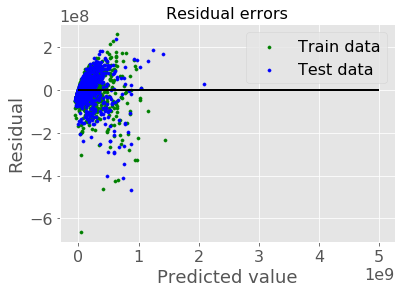

In [311]:
print('Coefficients: \n', reg.coef_) 
print('Intercept: \n', reg.intercept_) 
# variance score: 1 means perfect prediction 
print('Variance score: {}'.format(reg.score(X_test, y_test)))

## plotting residual errors in training data 
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, 
            color = "green", s = 10, label = 'Train data') 
  
## plotting residual errors in test data 
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Test data') 
  
## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 50*10**8, linewidth = 2) 
  
## plotting legend 
plt.legend(loc = 'upper right') 
  
## plot title 
plt.title("Residual errors") 
  
plt.xlabel('Predicted value')
plt.ylabel('Residual')
## function to show plot 
plt.show() 

In [312]:
Lasso_coefficients = reg.coef_
Lasso_intercept = reg.intercept_


print(Lasso_coefficients)
print(Lasso_intercept)

#Zip eller plot dem sammen

[ 8.72698446e-01  2.01474801e+00  1.80827149e+06 -4.67397540e+04
  1.20146155e+06  4.41929394e+06  7.89202117e+06 -1.06744999e+07
  8.18720665e+06 -9.99962253e+05  3.89719294e+06  6.52458220e+06
  2.17023163e+07 -9.86064349e+06  3.62236089e+07  2.21270053e+07
 -6.73696450e+06  1.53023227e+07  6.85436414e+06 -1.57317950e+06
  6.01467234e+06  5.39456356e+07 -1.97697679e+07 -9.60688172e+06
 -2.30113501e+07]
-40917203.55770601


In [313]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                    Train          Test
sample size                            
305          2.479072e+16  2.740801e+16
320          2.418055e+16  2.739011e+16
336          2.443643e+16  2.736604e+16


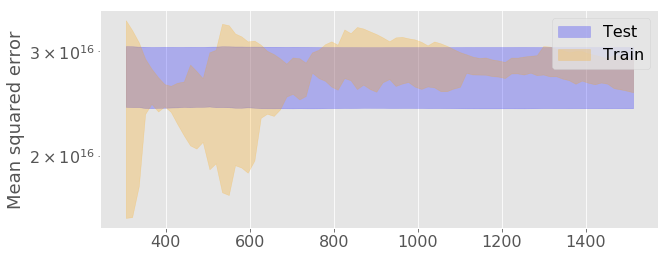

In [314]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [315]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
615848.211066    1.318634e+16
Name: Validation, dtype: float64


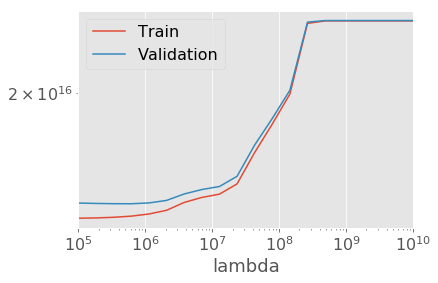

In [316]:
mse_score.plot(logx=True, logy=True)

#overfitter fordi den er bedre på train end validation

plt.scatter(y_train_pred,  y_train_pred - y_train,
             c='steelblue', marker='o', edgecolor='white',
             label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
             c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

## Prediction of the cumulative gross in relation to the budget

In [323]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output=[]

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y2, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)
    
    output.append([rmse(reg.predict(X_val), y_val),
                  rmse(reg.predict(X_test), y_test)])
    
print(pd.DataFrame(output, columns=['test', 'validation']))

print(pd.DataFrame(output, columns=['test', 'validation']).describe())

           test  validation
0  53698.270616  116.099444
1  53698.270616  116.099444
2  53698.270616  116.099444
3  53698.270616  116.099444
4  53698.270616  116.099444
5  53698.270616  116.099444
6  53698.270616  116.099444
7  53698.270616  116.099444
8  53698.270616  116.099444
9  53698.270616  116.099444
               test    validation
count     10.000000  1.000000e+01
mean   53698.270616  1.160994e+02
std        0.000000  1.497956e-14
min    53698.270616  1.160994e+02
25%    53698.270616  1.160994e+02
50%    53698.270616  1.160994e+02
75%    53698.270616  1.160994e+02
max    53698.270616  1.160994e+02


In [324]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

lambdas = np.logspace(5,10,20)
# outer loop: lambdas
rmseCV = []
perform = []

for lambda_ in lambdas:    
    # inner loop: folds. For each of the folds (Splits),
    rmseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                         StandardScaler(),
                                         PolynomialFeatures()
                                     ), [0,1]), 
                                      ("", 'passthrough', [i for i in range(2, X.shape[1])])
                                     ]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_train, y_train, = X_dev.iloc[train_idx], y_dev[train_idx] #Selection where we throw in the indices and take out the data
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)  #Fit the model on the training data, estimation
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_val), y_val))   #Apply the model to the validation data and store it in an empty list
    #y_val_pred = pipe_lassoCV.predict(X_val)
    #y_train_pred = pipe_lassoCV.predict(X_train)
    #y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))
    # store result    
    rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(rmseCV, index=lambdas)

lambdaCV

optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda



100000.0    12810.612526
dtype: float64

In [322]:
X2

,rating,runtime,War,Mystery,Horror,Comedy,Fantasy,Crime,Thriller,Music,...,Film-Noir,Western,Adventure,Drama,Biography,Romance,Musical,Family,Action,Sport
title,,,,,,,,,,,,,,,,,,,,,
300: Rise of an Empire,6.2,102.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Afsløring,6.1,128.0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
Psycho,8.5,109.0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Divergent,6.7,139.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
X-Men 2,7.4,134.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
Freddy's Dead: The Final Nightmare,4.9,89.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Øje for øje,7.9,135.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Christmas Story,8.0,94.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Seabiscuit,7.3,140.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Notes for machine learning

Use predictions. But be careful, look at decisions when it is launced only. 


How predictive are these features for estimating future earnings? You can say what happens to gross whne I have the feature and exclude it. What happens?

What model should we use, try the ols or the 

run the lasso and allow the regularization - check whether the hyperparameter is really close to ols and check to see if all features are included. Check to see if the lasso is redundent for our case. If the lasso doesn't exclude any features and lambda is like ols you could just use ols. 

Remember to comment on bias. Is there something correlated with the error term?

Our data is continous which is why we've used the root squared mean error (RMSE) as our accuracy measure. 

1. 

The ridge and lasso determines lasso, when we start estimating we could fix it at a certain order but could also make it a hyperparameter. We optimize over these lambdas at our validation set. First we split the data in order to have an honest. the more data you have the less you need for testing. we've chosen a distribution of blabla. With polynomial transformation.

2. 
After we have the data split we make a model. We take all of our polynomial, scaling and our supervised learning model to make it a pipeline. It gives a clean overview of what we've done. 

3. 

We have build a pipeline. If we have hyperparameters then we want to optimise these. we split the development into one to fit and one to validate. Subdatasets. We take the one that performs best on the validation data. Because we believe this one will perform best on the test data. 

We estimate the model with the optimal hyperparameter and can go to the test data now.

USE CV, Cross validation. 

Use cv to find the optimal hyperparameters. Cross validation is the loop thing in range 10. So we take the average best on all of the validation sets. This is to avoid that we've just got a lucky draw. USE CV PLEASE AMALIE TAG DIG SAMMEN. We use it in the inner way to find the hyperparameter. We can also use it in the outer way on the whole set. So we also rotate which has to be the test data each time. So the split of test and development and afterwards in the inner level for the train and validation on the development data. HYPERPARAMETERS ARE ON THE INNER LEVEL.

REMEMBER TO CHECK FOR TIME SERIES 

5. Now we fit the model using all the data in the development set. Afterwards you test it on the test set. 

If you want to say these features add this much? Then you should just plot the distributions and comment on the similarity. 

If we asume all are independt and can sample them statically. For each of the test we use the non test data to make our model 10 times. Then we have do this with and without the features we're testing for. 



A comprehensive guide for how to earn money on movies in hollywood, trying to see which feautures affect the gross most and if you want a surtain audience you should make this genre.



## Code for plots

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Ratings function (main function)
## Will scrape each ranking URL from relevant data.
### Title is gathered by selector while the rankings are gathered by HTML converted into list which then is calculated

In [13]:
################### sub function making a list and from list created variables in main function ###################
def find_ratings(soup, rate):        
    for i in soup.select("#main > section > div > table:nth-child(14)")[0].find_all('div', class_='bigcell'):
        rate.append(i.text)
# find_ratings(BeautifulSoup(requests.get("https://www.imdb.com//title/tt0266543/ratings").text, "html.parser"))        
# rate


def ratings_extractor(url):
    r_r, call_id = connector.get(url, "ROFLMAO")
    soup_ = BeautifulSoup(requests.get(url).text, "html.parser")
    rate = []
    try:
        title = soup_.select("#main > section > div > div.subpage_title_block > div > div.parent > h3 > a")[0].text
        find_ratings(soup_,rate)
        check = [float(i) for i in rate]
        rate_all = [float(i) for i in rate][0]
        rate_young = float(round(np.array(list(np.array([float(i) for i in rate])[[1, 2, 6, 7, 11, 12]])).sum()/6, 2)) 
        rate_old = float(round(np.array((np.array([float(i) for i in rate])[[3,4,8,9,13,14]])).sum()/6, 2))
        rate_male = [float(i) for i in rate][5]
        rate_female = [float(i) for i in rate][10]
    except:
        title = None
        rate_all = None
        rate_young = None
        rate_old = None
        rate_male = None
        rate_female = None
    return {
        'title': title,
        'rate_all': rate_all,
        'rate_young': rate_young,
        'rate_old': rate_old,
        'rate_male': rate_male,
        'rate_female': rate_female
        }
ratings_extractor('https://www.imdb.com//title/tt0218817/ratings') #fordi den bliver None, skal de fjernes efter

{'title': None,
 'rate_all': None,
 'rate_young': None,
 'rate_old': None,
 'rate_male': None,
 'rate_female': None}

# Gathering all titles and their rankings using main function. 
## Each ranking url has it's own dictionary. Each dictionary is stored as a list

In [14]:
# rankings for each films are stored in links_r
links_r = [x+'ratings' for x in links]
res_r = []
# for idx, i in enumerate(links_r):
#     print(idx + 1, "of", len(links_r))
#     res_r.append(ratings_extractor(i))
    
    

# links_r[26] #det er link nummer 27 der forvolder problemer

# Translating the list of dictionaries into a DataFrame
## rankings-DataFrame

In [25]:
# df_r = pd.DataFrame(res_r).dropna() #dropper de film der mangler ratings fra en bestemt gruppe


# df_r.to_pickle('all_ratings.pkl') #husk kun at brug når data skal uploades/gemmes
df_r = pd.read_pickle('all_ratings.pkl').dropna() #husk kun at brug når data skal downloades/hentes
df_r = df_r.set_index(df_r['title'], drop=True)
del df_r['title']
df_r



,rate_all,rate_female,rate_male,rate_old,rate_young
title,,,,,
Recep Ivedik,4.6,3.5,4.8,4.27,4.83
Breaking Dawn - del 1,4.9,5.8,4.3,5.13,5.18
Giftig viden,7.1,6.9,7.1,7.12,7.20
En lang forlovelse,7.6,7.7,7.6,7.63,8.38
"Du almægtige, Evan",5.4,5.6,5.3,5.53,5.67
Hotel Mumbai,7.6,7.9,7.5,7.60,7.97
Little Miss Sunshine,7.8,7.9,7.8,7.80,7.98
Det hemmelighedsfulde selskab,5.8,6.2,5.8,5.90,5.95
Lords of Dogtown,7.1,7.3,7.1,6.93,7.40


# Merging movie-attribute-DataFrame with rankings-DataFrame, using innerjoin on the movie titles

In [26]:
df_master = pd.merge(df2, df_r, on='title', how='inner')
df_master['return'] = round(df_master['cumulative_world_gross']/df_master['budget'],2)
df_master

,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Horror,Musical,Mystery,Drama,rate_all,rate_female,rate_male,rate_old,rate_young,return
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,0,0,0,1,4.9,5.8,4.3,5.13,5.18,6.47
Giftig viden,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,0,0,1,7.1,6.9,7.1,7.12,7.20,5.57
En lang forlovelse,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,0,0,1,1,7.6,7.7,7.6,7.63,8.38,1.23
"Du almægtige, Evan",175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,0,0,5.4,5.6,5.3,5.53,5.67,0.99
Little Miss Sunshine,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,...,0,0,0,1,7.8,7.9,7.8,7.80,7.98,12.57
Det hemmelighedsfulde selskab,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,0,0,0,0,5.8,6.2,5.8,5.90,5.95,2.30
Lords of Dogtown,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,0,0,0,1,7.1,7.3,7.1,6.93,7.40,0.54
Freddy Got Fingered,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,0,4.6,3.9,4.7,4.00,4.87,1.02
Lunefulde måne,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,1,7.1,7.3,7.0,7.18,7.52,5.38


In [33]:
def category_summary(df, category, categories):
    categories = list(categories)
    stats = ["rate_all", "rate_female", "rate_male", "rate_old", "rate_young"]
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 




print(category_summary(df_master, "Fantasy", ["Fantasy"])) #examples
print(category_summary(df_master, "Horror", ["Horror"])) #exmaples

rated = []
for idx, i in enumerate(categories):
    print(idx+1, 'of', len(categories))
    rated.append(category_summary(df_master, i, [i]))
    
# rated 
df_rated=pd.DataFrame(rated, index=categories)
df_rated

#Check at categories er defineret ud fra hvilke genre der rent faktisk er i datasættet

rate_all       6.463314
rate_female    6.653846
rate_male      6.397337
rate_old       6.469467
rate_young     6.621006
dtype: float64
rate_all       6.131702
rate_female    6.180653
rate_male      6.106527
rate_old       6.111329
rate_young     6.212774
dtype: float64
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
21 of 21


,rate_all,rate_female,rate_male,rate_old,rate_young
Family,6.362397,6.662810,6.229752,6.374876,6.516240
Fantasy,6.463314,6.653846,6.397337,6.469467,6.621006
History,7.187129,7.329703,7.140594,7.180792,7.352475
Sci-Fi,6.510089,6.563501,6.491691,6.482819,6.564303
Adventure,6.549937,6.704930,6.505689,6.541340,6.678938
Comedy,6.434578,6.528896,6.375649,6.371088,6.648969
War,7.475472,7.513208,7.450943,7.425660,7.656792
Romance,6.626200,6.752400,6.533800,6.570260,6.865940
Film-Noir,8.200000,8.100000,8.200000,8.185000,8.375000
Action,6.420532,6.524255,6.393404,6.395277,6.610819


In [34]:
def genre_stats(df, category, categories):
    categories = list(categories)
    stats = ["cumulative_world_gross", "budget", 'rating']
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 
#husk at inkluder antallet af observationer pr. genre

print(genre_stats(df_master, "Musical", ["Musical"]))


money = []
for idx, i in enumerate(categories):
    money.append(genre_stats(df_master, i, [i]))
    
# rated 
df_money=pd.DataFrame(money, index=categories)
df_money['genres']=categories
df_money['profit']=df_money['cumulative_world_gross']-df_money['budget']
df_money['return']=round(df_money['cumulative_world_gross']/df_money['budget'],2)
df_money['rating']=round(df_money['rating'],2)

df_money

cumulative_world_gross    1.260306e+08
budget                    3.150613e+07
rating                    6.927778e+00
dtype: float64


,cumulative_world_gross,budget,rating,genres,profit,return
Family,2.058977e+08,5.898660e+07,6.37,Family,1.469111e+08,3.49
Fantasy,1.888587e+08,5.871492e+07,6.44,Fantasy,1.301438e+08,3.22
History,9.169667e+07,3.973344e+07,7.21,History,5.196323e+07,2.31
Sci-Fi,1.952270e+08,6.335499e+07,6.50,Sci-Fi,1.318720e+08,3.08
Adventure,2.638057e+08,7.880877e+07,6.54,Adventure,1.849969e+08,3.35
Comedy,1.271205e+08,3.850456e+07,6.43,Comedy,8.861599e+07,3.30
War,7.519394e+07,2.755566e+07,7.48,War,4.763828e+07,2.73
Romance,9.401955e+07,2.856073e+07,6.62,Romance,6.545882e+07,3.29
Film-Noir,1.293296e+06,1.290500e+06,8.20,Film-Noir,2.796000e+03,1.00
Action,1.929168e+08,6.738842e+07,6.40,Action,1.255284e+08,2.86


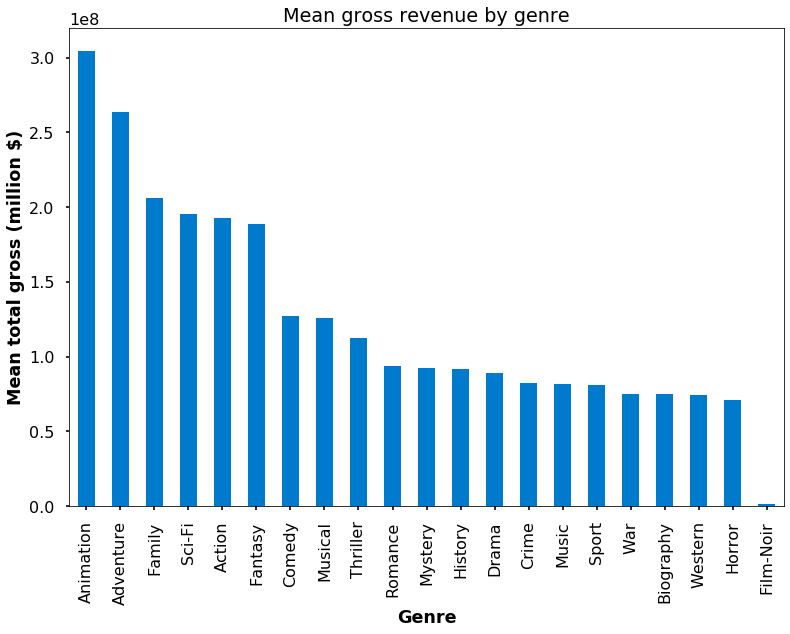

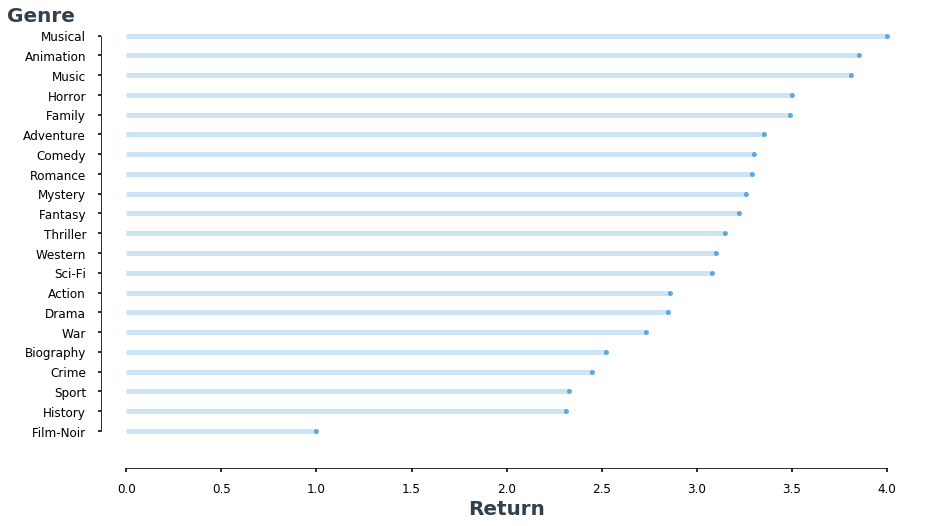

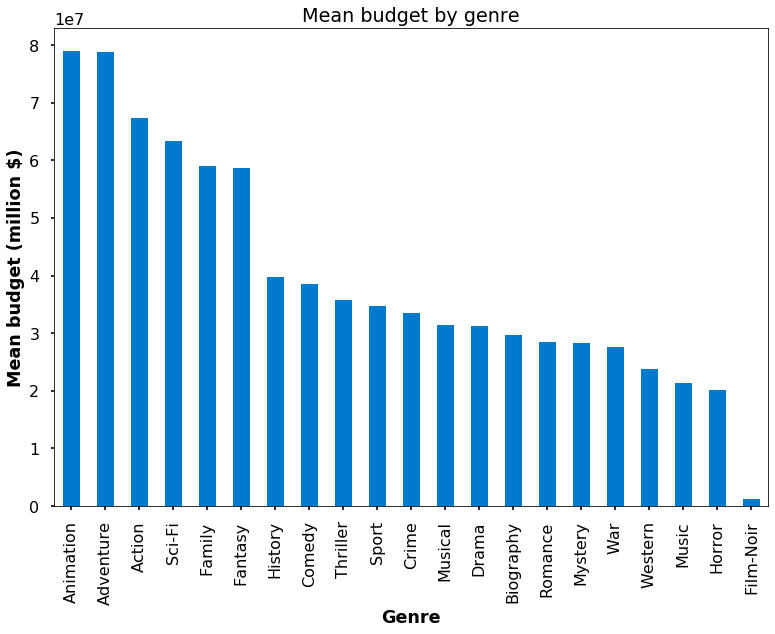

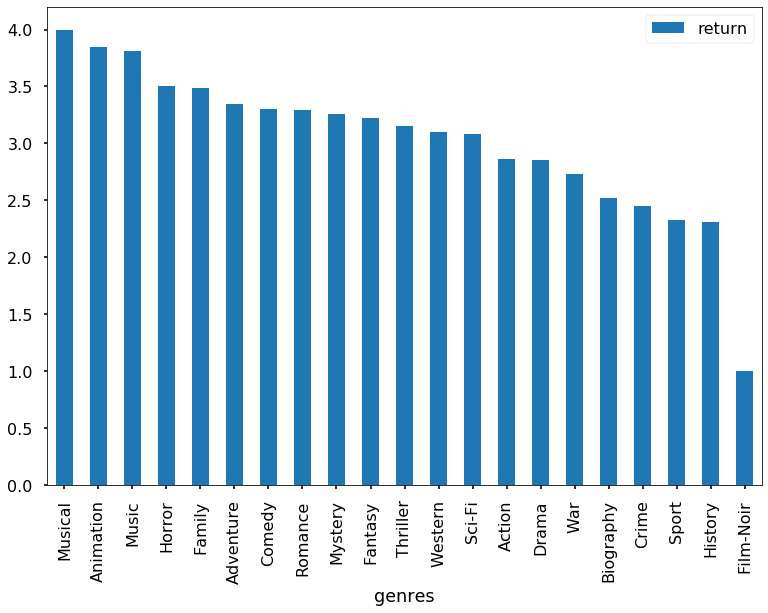

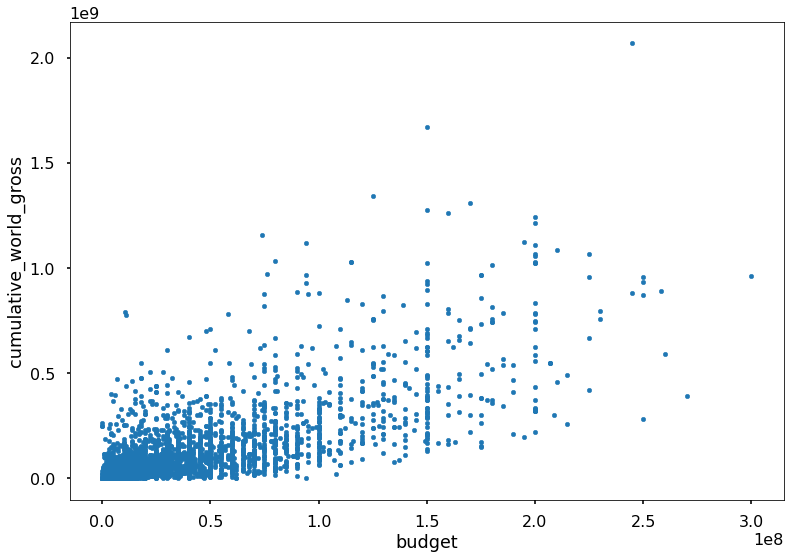

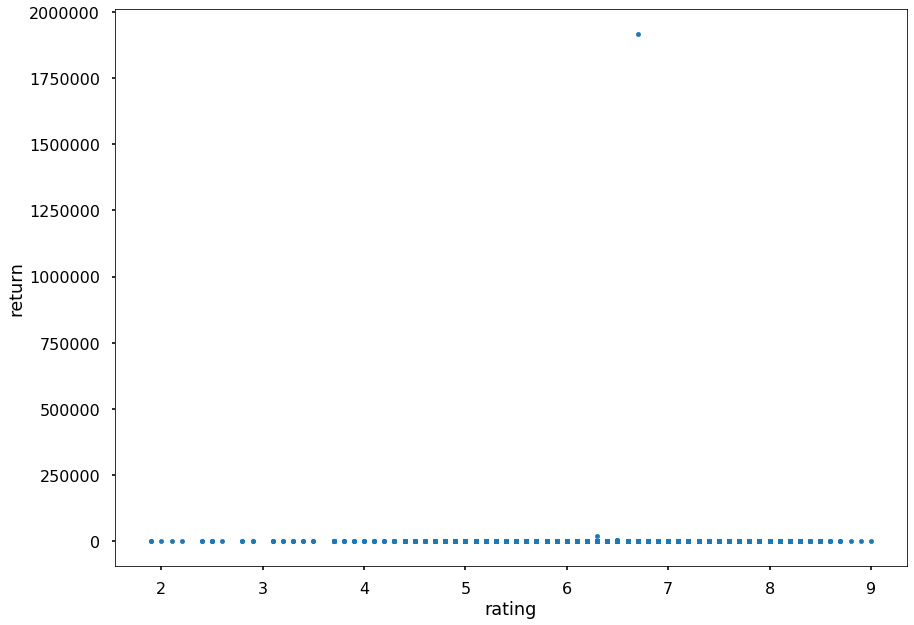

In [35]:
import matplotlib.style as style
style.use('seaborn-poster')

barplot1 = df_money.sort_values('cumulative_world_gross', ascending=False).plot.bar(x='genres', y='cumulative_world_gross', title='Mean gross revenue by genre', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
barplot1.set_ylabel('Mean total gross (million $)', weight='bold')
barplot1.set_xlabel('Genre', weight='bold')





df_money = df_money.sort_values(by='return')
my_range = list(range(1,len(df_money.index)+1))
fig, ax = plt.subplots(figsize=(15,8))
plt.hlines(y=my_range, xmin=0, xmax=df_money['return'], color='#007acc', alpha=0.2, linewidth=5)
plt.plot(df_money['return'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
ax.set_xlabel('Return', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df_money.index)
fig.text(0.05, 0.87, 'Genre', fontsize=20, fontweight='black', color = '#333F4B')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))


barplot2 = df_money.sort_values('budget', ascending=False).plot.bar(x='genres', y='budget', title='Mean budget by genre', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
barplot2.set_ylabel('Mean budget (million $)', weight='bold')
barplot2.set_xlabel('Genre', weight='bold')

df_money.sort_values('return', ascending=False).plot.bar(x='genres', y='return')

df_master.plot.scatter(x='budget', y='cumulative_world_gross')#brugt master
df_master.plot.scatter(x='rating', y='return')#brugt master

plt.tight_layout()
plt.show()




# ax = sns.barplot(y= "Deaths", x = "Causes", data = deaths_pd, palette=("Blues_d"))
# sns.set_context("poster") palette
